## **This notebook is to build a recurrent neural network model to classifiy IMDB movie/TV comments (positive or negative) using tensorflow LSTM layer. The model performs remarkably well with 96% accuracy.**

## import Modules/packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil


## Load the IMDB data into tensorflow data.Dataset

In [2]:
# download and upzip file by calling tensorflow utils.get_file 
tf.keras.utils.get_file(fname='aclImdb_v1',origin='https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                        cache_subdir='/content/',extract=True)

'/content/aclImdb_v1'

In [3]:
# remove the 'unsup' folder
shutil.rmtree('aclImdb/train/unsup') 

In [4]:
# display a sample
!cat aclImdb/train/pos/0_9.txt

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

In [5]:
# Since train dataset and test dataset are in the different directories, they are loaded separately
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=32,
    label_mode='binary',
    seed=1337)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=32,label_mode='binary',
    seed=1337)

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Number of batches in raw_train_ds: 782
Number of batches in raw_test_ds: 782


In [7]:
# Concatenate the train and test and perform shuffle and split into train data, validation data and test data respectively
# Shuffle step is important because I want to make sure the data are randomly distributed in train and test data
all_data=raw_train_ds.concatenate(raw_test_ds)
DATASET_SIZE=int(f"{all_data.cardinality()}")
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_ds = all_data.shuffle(buffer_size=DATASET_SIZE)
raw_train_ds = full_ds.take(train_size)
remaining = full_ds.skip(train_size)  
raw_val_ds = remaining.take(val_size)
raw_test_ds = remaining.skip(test_size)

In [8]:
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Number of batches in raw_train_ds: 1094
Number of batches in raw_val_ds: 234
Number of batches in raw_test_ds: 236


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'This movie seems to start in the middle, introduces peripheral players as if they were significant and presents main characters without any substance and paper-thin and/or impenetrable back-stories. Almost nobody has a credible or discernible motivation for their actions in this film. The plot rambles and ultimately goes nowhere, the dialogue is clunky and trite and the director has little concept of how to get the best from his actors. It almost feels like there\'s a first half of this movie but it never got made.<br /><br />We\'re told that a mysterious pyramid has appeared over New York City and that Central Park has inexplicably become an arctic wasteland. Yet none of this seems to have caused much of a stir amongst the general population and is only of minimal concern to the government.<br /><br />We\'re presented with the "evil corporation" in Eugenics but that\'s really just a convenient conceit to populate the universe with a couple power-tripping minions. The whole "Eugenics

## Prepare and Vectorize the data

In [10]:
from tensorflow.keras.layers import TextVectorization
import string
import re

In [11]:
# create a custom standardization function to remove '<br />'.

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [12]:
# instantiate a text vectorization layer. Use this layer to normalize, split, and map
# strings to integers ('output_mode' to 'int').

vectorize_layer=TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

In [13]:
# Use the .adapt to get a vocabulary of the data
text_ds=raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(text_ds)

In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [15]:
for text,label in train_ds.take(1):
  print(text,label)

tf.Tensor(
[[   2  189   12 ...    0    0    0]
 [  10  235   54 ...    0    0    0]
 [  10   41  174 ...    0    0    0]
 ...
 [   2  111   13 ...    0    0    0]
 [1055 1845 3884 ...    0    0    0]
 [  11    7 4458 ...    0    0    0]], shape=(32, 500), dtype=int64) tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)


## Build and train a model

In [16]:
# Build a model using fuctional API

from tensorflow.keras import layers

inputs=tf.keras.Input(shape=(None,),dtype='int64')
x=layers.Embedding(max_features,embedding_dim,name='embeddings_layer')(inputs)
x=layers.Bidirectional(tf.keras.layers.LSTM(64),name='LSTM_layer')(x)
x = layers.Dense(64, activation="relu",name='dense_layer')(x)
predictions = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model = tf.keras.Model(inputs, predictions)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# Train the model
epochs=15
model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/15
1094/1094 [==============================] - 83s 64ms/step - loss: 0.4594 - accuracy: 0.7834 - val_loss: 0.3160 - val_accuracy: 0.8886
Epoch 2/15
1094/1094 [==============================] - 62s 57ms/step - loss: 0.3244 - accuracy: 0.8694 - val_loss: 0.5218 - val_accuracy: 0.7635
Epoch 3/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.2462 - accuracy: 0.9074 - val_loss: 0.2099 - val_accuracy: 0.9237
Epoch 4/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.1915 - accuracy: 0.9325 - val_loss: 0.2149 - val_accuracy: 0.9223
Epoch 5/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.1545 - accuracy: 0.9453 - val_loss: 0.2011 - val_accuracy: 0.9368
Epoch 6/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.1015 - accuracy: 0.9662 - val_loss: 0.2568 - val_accuracy: 0.9319
Epoch 7/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.0886 - accuracy: 0.9712 - val_loss: 0.1731 -

## Evaluate the model

In [18]:
# Plot the accuracy and loss during training process

def accuracy_loss_plot(input):
  import matplotlib.pyplot as plt

  df=pd.DataFrame.from_dict(input)
  fig, (axe1,axe2)=plt.subplots(1,2)
  axe1.plot(df['accuracy'],label='train')
  axe1.plot(df['val_accuracy'],label='val')
  axe1.set_title('Accuracy')
  axe1.legend()

  axe2.plot(df['loss'],label='train')
  axe2.plot(df['val_loss'],label='val')
  axe2.set_title('loss')
  axe2.legend()
  plt.show()
  return df

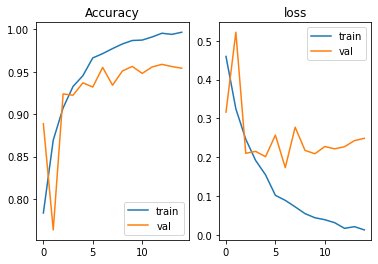

In [19]:
df=accuracy_loss_plot(model.history.history)

**As shown above, there is some degree of overfitting and variance**

In [ ]:
# Extract text and label in test_ds into list respectively
test_text=[]
test_label=[]

for text, label in test_ds.take(236):

  for i in range(32):
    test_text.append(text[i].numpy().tolist())
    test_label.append(label[i].numpy().tolist())

test_label = [item for sublist in test_label for item in sublist]

In [ ]:
# make a prediction on test data

prediction=model.predict(test_ds)

prediction=[1 if x>0.5 else 0 for x in prediction]

In [28]:
# define a function to plot the confusion_matrix

def cf_mx_map(y_test,y_pred,model_type):
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    print(f'{model_type}:','\n',classification_report(y_test, y_pred))
    
    plt.figure(figsize=[7,6])
    ax=sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,cmap="YlGnBu", annot_kws={"size": 15})
    ax.set_title('Confusion_matrix',fontsize = 20)
    plt.xlabel('Predicted', fontsize = 20) 
    plt.ylabel('Actual', fontsize = 20)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 20)
    #plt.xticks(np.arange(3),labels=['0:No','1:Yes'], rotation=90)
    #plt.yticks(np.arange(3),labels=['0:No','1:Yes'])
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.show()
    print('\n')

IMDB sentiment classification: 
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      3774
         1.0       0.94      0.97      0.96      3778

    accuracy                           0.95      7552
   macro avg       0.96      0.95      0.95      7552
weighted avg       0.96      0.95      0.95      7552



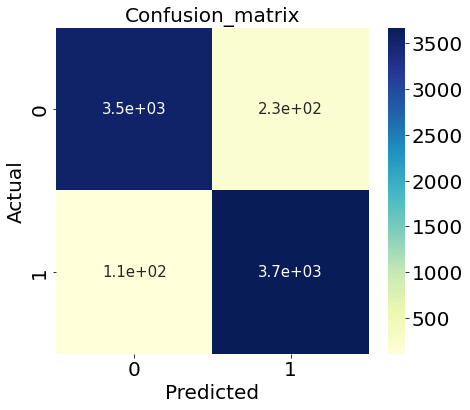

In [29]:
cf_mx_map(test_label,prediction,'IMDB sentiment classification')

# Fine-tune the model

## Dropout

In [32]:
# Add dropout to LSTM layer to reduce overfitting problem

from tensorflow.keras import layers

inputs=tf.keras.Input(shape=(None,),dtype='int64')
x=layers.Embedding(max_features,embedding_dim,name='embeddings_layer')(inputs)
x=layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.5),name='LSTM_layer')(x)
x = layers.Dense(64, activation="relu",name='dense_layer')(x)
predictions = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_opt = tf.keras.Model(inputs, predictions)

model_opt.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
# Train the model
epochs=15
model_opt.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/15
1094/1094 [==============================] - 66s 57ms/step - loss: 0.4772 - accuracy: 0.7767 - val_loss: 0.4049 - val_accuracy: 0.8281
Epoch 2/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.3340 - accuracy: 0.8612 - val_loss: 0.1967 - val_accuracy: 0.9268
Epoch 3/15
1094/1094 [==============================] - 63s 58ms/step - loss: 0.1976 - accuracy: 0.9264 - val_loss: 0.1794 - val_accuracy: 0.9347
Epoch 4/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.1506 - accuracy: 0.9449 - val_loss: 0.1537 - val_accuracy: 0.9510
Epoch 5/15
1094/1094 [==============================] - 63s 57ms/step - loss: 0.1084 - accuracy: 0.9632 - val_loss: 0.1480 - val_accuracy: 0.9559
Epoch 6/15
1094/1094 [==============================] - 62s 57ms/step - loss: 0.0803 - accuracy: 0.9740 - val_loss: 0.1428 - val_accuracy: 0.9599
Epoch 7/15
1094/1094 [==============================] - 62s 57ms/step - loss: 0.0578 - accuracy: 0.9824 - val_loss: 0.1508 -

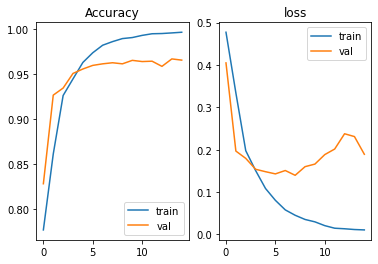

In [34]:
df=accuracy_loss_plot(model_opt.history.history)

**As shown above, Dropout smoothes the variance of both accuracy and loss although it does not solve overfitting issue in this case**

In [35]:
# make a prediction on test data

prediction_opt=model_opt.predict(test_ds)

prediction_opt=[1 if x>0.5 else 0 for x in prediction_opt]
print(prediction_opt[0:10])

[0, 0, 1, 1, 0, 0, 0, 1, 1, 1]


IMDB sentiment classification: 
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      3774
         1.0       0.97      0.97      0.97      3778

    accuracy                           0.97      7552
   macro avg       0.97      0.97      0.97      7552
weighted avg       0.97      0.97      0.97      7552



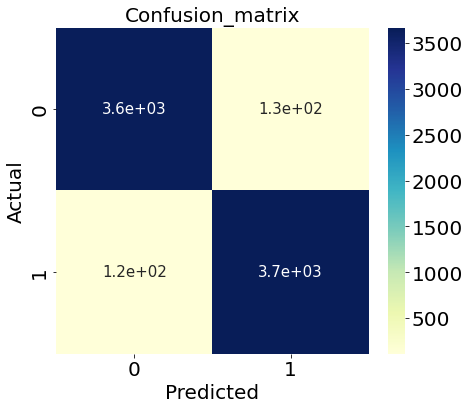

In [36]:
cf_mx_map(test_label,prediction_opt,'IMDB sentiment classification')

## Early stopping

In [42]:
# Add dropout to LSTM layer to reduce overfitting problem

from tensorflow.keras import layers

inputs=tf.keras.Input(shape=(None,),dtype='int64')
x=layers.Embedding(max_features,embedding_dim,name='embeddings_layer')(inputs)
x=layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.5),name='LSTM_layer')(x)
x = layers.Dense(64, activation="relu",name='dense_layer')(x)
predictions = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_opt2 = tf.keras.Model(inputs, predictions)

model_opt2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [43]:
# Train the model
epochs=15
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model_opt2.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=[callback])

Epoch 1/15
1094/1094 [==============================] - 65s 55ms/step - loss: 0.4840 - accuracy: 0.7685 - val_loss: 0.3239 - val_accuracy: 0.8765
Epoch 2/15
1094/1094 [==============================] - 63s 58ms/step - loss: 0.4256 - accuracy: 0.8077 - val_loss: 0.4064 - val_accuracy: 0.8425
Epoch 3/15
1094/1094 [==============================] - 64s 59ms/step - loss: 0.2807 - accuracy: 0.8877 - val_loss: 0.1829 - val_accuracy: 0.9332
Epoch 4/15
1094/1094 [==============================] - 64s 59ms/step - loss: 0.1722 - accuracy: 0.9388 - val_loss: 0.1740 - val_accuracy: 0.9427
Epoch 5/15
1094/1094 [==============================] - 64s 59ms/step - loss: 0.1287 - accuracy: 0.9554 - val_loss: 0.1596 - val_accuracy: 0.9494
Epoch 6/15
1094/1094 [==============================] - 64s 59ms/step - loss: 0.1069 - accuracy: 0.9635 - val_loss: 0.1433 - val_accuracy: 0.9555
Epoch 7/15
1094/1094 [==============================] - 64s 59ms/step - loss: 0.0792 - accuracy: 0.9749 - val_loss: 0.1460 -

IMDB sentiment classification: 
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3774
         1.0       0.95      0.97      0.96      3778

    accuracy                           0.96      7552
   macro avg       0.96      0.96      0.96      7552
weighted avg       0.96      0.96      0.96      7552



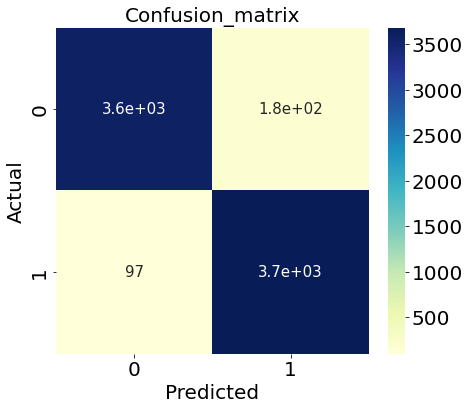

In [44]:
# make a prediction on test data

prediction_opt2=model_opt2.predict(test_ds)

prediction_opt2=[1 if x>0.5 else 0 for x in prediction_opt2]
cf_mx_map(test_label,prediction_opt2,'IMDB sentiment classification')

In [45]:
model.save('/content/drive/MyDrive/Colab Notebooks/RNN NLP etc/')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/RNN NLP etc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/RNN NLP etc/assets


In [46]:
model.save('/content/drive/MyDrive/Colab Notebooks/RNN NLP etc/my_h5_model.h5')

# Conclusion
LSTM-based model performs very well in text classifiction with 96% accuracy.